## Access Kaggle
Serveral things you need to do to access Kaggle
- Sign in to Kaggle and join the competition called **BCI Homework 3 Kaggle Judge** (using the link we provide in the document)

- Create your own kaggle API token (in your account->API)
  
  <img src="https://i.imgur.com/Gia6TwE.png" alt="drawing" width="800"/>
- Upload API token (.json file) to Colab

   <img src="https://i.imgur.com/xjEXBYs.png" alt="drawing" width="200"/>

In [39]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions list

ref                                                                               deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/llm-detect-ai-generated-text                  2024-01-22 23:59:00  Featured          $110,000       2516           False  
https://www.kaggle.com/competitions/optiver-trading-at-the-close                  2023-12-20 23:59:00  Featured          $100,000       4155           False  
https://www.kaggle.com/competitions/nfl-big-data-bowl-2024                        2024-01-08 23:59:00  Analytics         $100,000          0           False  
https://www.kaggle.com/competitions/blood-vessel-segmentation                     2024-02-06 23:59:00  Research           $80,000        278           False  
https://www.kaggle.com/competitions/linking-wr

## Download Dataset from Kaggle

In [40]:
!kaggle competitions download -c bci-homework-3-kaggle-judge-fall
!unzip -qq bci-homework-3-kaggle-judge-fall.zip -d ./
!ls -l BCI_hw3_dataset

bci-homework-3-kaggle-judge-fall.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./BCI_hw3_dataset/data_detail.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
total 16
-rw-r--r-- 1 root root  269 Nov 16 05:01 data_detail.json
drwxr-xr-x 2 root root 4096 Dec 14 18:52 labeled_test
drwxr-xr-x 2 root root 4096 Dec 14 18:52 train
drwxr-xr-x 2 root root 4096 Dec 14 18:52 unlabeled_test


## Install Package (Optional)

In [41]:
!pip install torchinfo
!pip install mne

## Import Package and Library to Python Session

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F

from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import math
import time
import csv
import mne
import sys
import os

DATASET_DIR = "BCI_hw3_dataset/train"
DATASET_DIR_TEST = "BCI_hw3_dataset/labeled_test"
DATASET_DIR_EXAM = "BCI_hw3_dataset/unlabeled_test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## EEG Model

### EEGNet

In [43]:
class EEGNet(nn.Module):
    """EEGNet model from Lawhern et al 2018.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    kernLength: int
        Length of temporal convolution in first layer.
    F1, F2: int
        Number of temporal filters (F1) and number of pointwise filters (F2) to learn.
    D: int
        Number of spatial filters to learn within each temporal convolution.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1611.08024
    """
    def __init__(self, C, N, nb_classes, kernLength=64, F1=8, F2=16, D=2, dropoutRate=0.5):
        super(EEGNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding="valid", bias=False),
            nn.BatchNorm2d(F1, eps=1e-3, momentum=0.99)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                F1, D * F1, (C, 1), groups=F1, bias=False
            ),
            nn.BatchNorm2d(D * F1, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                D * F1, D * F1, (1, 16),
                padding=(0, 8), groups=D * F1, bias=False
            ),
            nn.Conv2d(D * F1, F2, (1, 1), bias=False),
            nn.BatchNorm2d(F2, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )

        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### SCCNet

In [44]:
# (Bonus) Optional TODO: Advanced SCCNet model without permutation layer
class SCCNet_v2(nn.Module):
    """Advanced SCCNet model without permutation layer.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet_v2, self).__init__()
        Nu = C if Nu is None else Nu
        # self.layer = ...
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=Nu, kernel_size=(C, Nt), padding=0),
            nn.BatchNorm2d(Nu),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=Nu, out_channels=Nc, kernel_size=(1, 12), padding=0),
            nn.BatchNorm2d(Nc),
            nn.ReLU(inplace=True)
        )

        self.dropout = nn.Dropout(dropoutRate)
        self.avgpool = nn.AvgPool2d(kernel_size=(1, 62), stride=(1, 12))

        fc_in_size = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_in_size, nb_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x ** 2
        x = self.dropout(x)
        x = self.avgpool(x)
        x = torch.log(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.avgpool(x)
        x = x.view(x.size()[0], -1)
        return x.size()

In [45]:
# TODO: finish the SCCNet
class SCCNet(nn.Module):
    """SCCNet model from Wei et al 2019.
    Note: Nc was misused in the paper to describe both the number of EEG input channels and the number of spatial-temporal kernel.
    Please refer to the following description to find the correspondence of the defined parameters and noataions in the paper.
    ... Parameters ............
    C: int
        Number of EEG input channels. (Same as the Nc mentioned in the first and second paragraphs of the paper section II.B)
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel. (Same as the Nc mentioned in the third paragraph of the paper section II.B)
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    # You can only add extra argument to this function, do NOT remove the existed arguments
    # The model structure should be dynamic changed by the provided arguments,
    # There will be a score penalty if SCCNet structure is static
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet, self).__init__()
        Nu = C if Nu is None else Nu
        ### TODO: construct the model layers, refer to paper ###
        # self.layer = ...
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=Nu, kernel_size=(C, Nt), padding=0),
            Permute2d((0,2,1,3)),
            # Permute2d((2,1,3)),
            nn.BatchNorm2d(1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=Nc, kernel_size=(Nu, 12), padding=0),
            nn.BatchNorm2d(Nc)
        )
        self.dropout = nn.Dropout(dropoutRate)
        self.Avgpool = nn.AvgPool2d(kernel_size=(1,62), stride=(1,12))

        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

    def forward(self, x):
        ### TODO: forwarding rule ###
        # ex. x = self.layer(x)
        # note. remember the square activation and log activation

        # Input shape : Batch,1,Channel,Timepoint
        x = self.conv1(x)
        x = self.conv2(x)
        x = x ** 2
        x = self.dropout(x)
        x = self.Avgpool(x)
        x = torch.log(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        # Optional TODO: auto calculate fully-connected layer helper function
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.Avgpool(x)
        x = x.view(x.size()[0], -1)
        return x.size()

class Permute2d(nn.Module):
    def __init__(self, shape):
        super(Permute2d, self).__init__()
        self.shape = shape

    def forward(self, x):
        return torch.permute(x, self.shape)

## Train

In [46]:
# config training scheme, mode, hyperparam
# --------SCCNet---------
eegmodel = SCCNet # function alias, should be EEGNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
# --------SCCNet---------

# --------EEGNet---------
# eegmodel = EEGNet
# kwargs = dict(dropoutRate=0.5)
# --------EEGNet---------

# --------SCCNet_v2---------
# eegmodel = SCCNet_v2
# kwargs = dict(fs=125.0, dropoutRate=0.5)
# --------SCCNet_v2---------

scheme = "all"  # "all", "easy"
# easy_list = ["01", "02", modify_this_list]  #TODO: Modify this list!!! Put the easy subject id here ex. ["01", "02" ......]
# perforamance 01 03 07 08 09
easy_list = ["01", "07", "08", "09"]
epochs = 250
batch_size = 16
lr = 1e-4
# savepath = "checkpoints/EEGNet_" + "SI"
# savepath2 = "checkpoints/EEGNet_" + "SIFI"
savepath = "checkpoints/SCCNet_" + "SI"
savepath2 = "checkpoints/SCCNet_" + "SIFI"
os.makedirs(savepath, exist_ok=True)
os.makedirs(savepath2, exist_ok=True)
subject_id = "03"

### load data(all)

In [47]:
# In this section, we need to create 2 dataloader, easy, all
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)
### for tra_all_loader and val_all_loader
for sid in [f"{i:02d}" for i in range(1, 10)]:
    if sid == subject_id:
        continue
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{sid}_T.mat"))
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_train = np.append(x_train, x_[:54], axis=0)
        y_train = np.append(y_train, y_[:54], axis=0)
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)


# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_all_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_all_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

train: torch.Size([1728, 1, 22, 562]), torch.Size([1728, 4])
valid: torch.Size([576, 1, 22, 562]), torch.Size([576, 4])


### load data (easy)

In [48]:
# In this section, we need to create 2 dataloader, easy, all
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)
### for tra_easy_loader and val_easy_loader
### TODO ###
### Create the data according to easy_list ###
for sid in easy_list:
  if sid == subject_id:
      continue
  mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{sid}_T.mat"))
  x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

  for c in range(4):
      x_, y_ = x_data[y_data == c], y_data[y_data == c]
      x_train = np.append(x_train, x_[:54], axis=0)
      y_train = np.append(y_train, y_[:54], axis=0)
      x_valid = np.append(x_valid, x_[54:], axis=0)
      y_valid = np.append(y_valid, y_[54:], axis=0)



# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_easy_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_easy_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

train: torch.Size([864, 1, 22, 562]), torch.Size([864, 4])
valid: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])


### training stage

In [49]:
# train an epoch, evaluate an epoch
# if you are familiar with Pytorch, you CAN custom these function
#  such as adding the lr_scheduler to optimize the training progress

def train_an_epoch(model, data_loader, loss_fn, optimizer):
    model.train()
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)


    a, b = 0, 0  # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TODO ###
        # TODO: zero grad optimizer
        optimizer.zero_grad()
        # TODO: get model prediction
        output = model(x_batch)
        # TODO: calc loss
        loss = loss_fn(output, y_batch)
        # TODO: back propagation
        loss.backward()
        # TODO: step the optimizer
        optimizer.step()

        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    scheduler.step()
    return epoch_loss.mean(), a / b  # return the loss and acc

def evalate_an_epoch(model, data_loader, loss_fn):
    model.eval()
    a, b = 0, 0 # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    gt = []  # List to store all predictions
    pred = []   # List to store all ground truth labels

    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TODO ###
        # TODO: get model prediction
        output = model(x_batch)
        # TODO: calc loss
        loss = loss_fn(output, y_batch)

        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()

        gt += y_batch.argmax(dim=1).detach().cpu().numpy().tolist()
        pred += output.argmax(dim=1).detach().cpu().numpy().tolist()
    return epoch_loss.mean(), a / b, gt, pred  # return the loss and acc


In [50]:
model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs).to(device)
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # optimizer, CAN be modified
# opt_fn = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# sche_fn = torch.optim.lr_scheduler.<???> # optional

# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
SCCNet                                   [16, 4]                   --
├─Sequential: 1-1                        [16, 1, 22, 562]          --
│    └─Conv2d: 2-1                       [16, 22, 1, 562]          506
│    └─Permute2d: 2-2                    [16, 1, 22, 562]          --
│    └─BatchNorm2d: 2-3                  [16, 1, 22, 562]          2
├─Sequential: 1-2                        [16, 20, 1, 551]          --
│    └─Conv2d: 2-4                       [16, 20, 1, 551]          5,300
│    └─BatchNorm2d: 2-5                  [16, 20, 1, 551]          40
├─Dropout: 1-3                           [16, 20, 1, 551]          --
├─AvgPool2d: 1-4                         [16, 20, 1, 41]           --
├─Linear: 1-5                            [16, 4]                   3,284
Total params: 9,132
Trainable params: 9,132
Non-trainable params: 0
Total mult-adds (M): 51.33
Input size (MB): 0.79
Forward/backward pass size (MB):

In [51]:
# if you are familiar with Pytorch, you CAN customize the following training loop
## TODO ##
curriculum_learning = True # True when curriculum learning / False when normal SI training scheme or normal SI+FT training scheme
if curriculum_learning:
    hist = dict(
        loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
        acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
    )
    clock_ini = time.time()
    ### TODO : Modify the loader according to your curriculum training scheme ###
    ### ex. tra_all_loader, val_all_loader, tra_easy_loader, val_easy_loader
    # ------------------- curriculum1----------------------
    tra_loader = tra_easy_loader
    val_loader = val_easy_loader
    # ------------------- curriculum1----------------------

    # ------------------- curriculum3----------------------
    # tra_loader = tra_all_loader
    # val_loader = val_all_loader
    # ------------------- curriculum3----------------------
    for ep in range(int(epochs/2)):
        loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
        loss, acc, _, _ = evalate_an_epoch(model, tra_loader, loss_fn)
        val_loss, val_acc, _, _ = evalate_an_epoch(model, val_loader, loss_fn)
        print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
        hist["loss"][ep] = loss
        hist["acc"][ep] = acc
        hist["val_loss"][ep] = val_loss
        hist["val_acc"][ep] = val_acc
    ### TODO
    ### ex. tra_all_loader, val_all_loader, tra_easy_loader, val_easy_loader

    # ------------------- curriculum1----------------------
    tra_loader = tra_all_loader
    val_loader = val_all_loader
    # ------------------- curriculum1----------------------

    # ------------------- curriculum3----------------------
    # tra_loader = tra_easy_loader
    # val_loader = val_easy_loader
    # ------------------- curriculum3----------------------

    for ep in range(int(epochs/2)):
        loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
        loss, acc, _, _ = evalate_an_epoch(model, tra_loader, loss_fn)
        val_loss, val_acc, _, _ = evalate_an_epoch(model, val_loader, loss_fn)
        print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep+int(epochs/2), loss, acc, val_loss, val_acc))
        hist["loss"][ep+int(epochs/2)] = loss
        hist["acc"][ep+int(epochs/2)] = acc
        hist["val_loss"][ep+int(epochs/2)] = val_loss
        hist["val_acc"][ep+int(epochs/2)] = val_acc


        if True:
            checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
            # torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep}.pth"))
            torch.save(checkpoint, os.path.join(savepath, f"SCCNet-ep{ep}.pth"))
    print("time spend: {:.2f} sec".format(time.time() - clock_ini))

else:
    hist = dict(
        loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
        acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
    )
    clock_ini = time.time()
    tra_loader = tra_all_loader
    val_loader = val_all_loader
    for ep in range(epochs):
        loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
        loss, acc, _, _ = evalate_an_epoch(model, tra_loader, loss_fn)
        val_loss, val_acc, _, _ = evalate_an_epoch(model, val_loader, loss_fn)
        print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
        hist["loss"][ep] = loss
        hist["acc"][ep] = acc
        hist["val_loss"][ep] = val_loss
        hist["val_acc"][ep] = val_acc

        if True:
            checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
            # torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep}.pth"))
            torch.save(checkpoint, os.path.join(savepath, f"SCCNet-ep{ep}.pth"))
    print("time spend: {:.2f} sec".format(time.time() - clock_ini))

Epoch 0: loss=1.3410, acc=0.3507, val_loss=1.3734, val_acc=0.3403
Epoch 1: loss=1.2946, acc=0.4132, val_loss=1.3414, val_acc=0.3750
Epoch 2: loss=1.2372, acc=0.4630, val_loss=1.2987, val_acc=0.3993
Epoch 3: loss=1.1953, acc=0.4815, val_loss=1.2685, val_acc=0.4028
Epoch 4: loss=1.1591, acc=0.5289, val_loss=1.2455, val_acc=0.4097
Epoch 5: loss=1.1172, acc=0.5648, val_loss=1.2155, val_acc=0.4340
Epoch 6: loss=1.0762, acc=0.5822, val_loss=1.1884, val_acc=0.4757
Epoch 7: loss=1.0409, acc=0.5903, val_loss=1.1606, val_acc=0.5069
Epoch 8: loss=1.0149, acc=0.5880, val_loss=1.1488, val_acc=0.4792
Epoch 9: loss=0.9735, acc=0.6447, val_loss=1.1181, val_acc=0.5417
Epoch 10: loss=0.9512, acc=0.6377, val_loss=1.1052, val_acc=0.5278
Epoch 11: loss=0.9100, acc=0.6655, val_loss=1.0740, val_acc=0.5833
Epoch 12: loss=0.8958, acc=0.6771, val_loss=1.0673, val_acc=0.5729
Epoch 13: loss=0.8633, acc=0.6921, val_loss=1.0434, val_acc=0.5764
Epoch 14: loss=0.8397, acc=0.6910, val_loss=1.0288, val_acc=0.5972
Epoch

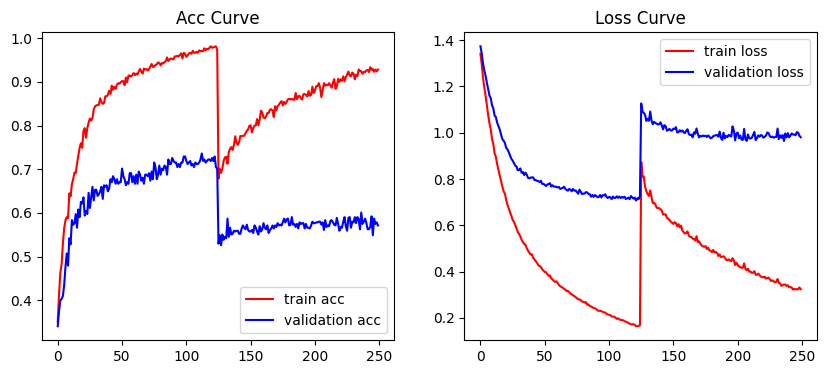

In [52]:
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red", label="train acc")
plt.plot(hist["val_acc"], color="blue", label="validation acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red", label="train loss")
plt.plot(hist["val_loss"], color="blue", label="validation loss")
plt.legend()
plt.show()

☁**Test**


In [58]:
# load pre-trained model
# TODO: determine the `BEST` epoch
# t_best_epoch = hist["loss"].argmin()
# print(t_best_epoch)

# -------------------------
start_epoch = 125
end_epoch = 250
best_epoch_within_range = np.argmin(hist["loss"][start_epoch:end_epoch])
print(best_epoch_within_range)
best_epoch = start_epoch + best_epoch_within_range
best_epoch = best_epoch - start_epoch
# -------------------------

# ------curriculum2-------
# best_epoch = hist["loss"].argmin()
# ------curriculum2-------

print("best epoch: {}".format(best_epoch))
# test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("SCCNet", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# testing on subject S01 test (E) session
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S01_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()
x = torch.from_numpy(x)
y = torch.from_numpy(y).long()
x = x.unsqueeze(1)
y = F.one_hot(y, 4)

print("test: {}, {}".format(x.size(), y.size()))

testset = torch.utils.data.TensorDataset(x, y)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
loss, acc, gt, pred = evalate_an_epoch(model, test_loader, loss_fn)
print(acc)

118
best epoch: 118
test: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])
0.7465277777777778


### fine-tuning (SI+FT)

In [59]:
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, ConcatDataset

### TODO: build the fine-tuning dataloader ###
# subject_id = "01"
mat = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat["x_train"], mat["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)

# mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
# x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

for c in range(4):
  x_, y_ = x_data[y_data == c], y_data[y_data == c]
  x_train = np.append(x_train, x_[:54], axis=0)
  y_train = np.append(y_train, y_[:54], axis=0)
  x_valid = np.append(x_valid, x_[54:], axis=0)
  y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_all_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_all_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)


# load pre-trained model
### TODO ###
# -----------------------
eegmodel = SCCNet
# -----------------------

# -----------------------
# eegmodel = EEGNet
# -----------------------

model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs).to(device)
model = model.to(device)
epochs = 50
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # optimizer, CAN be modified
ep_num = 124# TODO: the pre-trained epoch you want to tuning
model_path = os.path.join(savepath, "{}-ep{}.pth".format("SCCNet", ep_num))
checkpoint = torch.load(model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# # Optional: lock pre-trained weight
for name, param in model.named_parameters():
  if name in ['classifier.weight', 'classifier.bias']:
    param.requires_grad = True
    # param.requires_grad = False
parameters = filter(lambda p: p.requires_grad, model.parameters())

### TODO: fine-tuning training loop ###
hist = dict(
  loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
  acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
)
clock_ini = time.time()
tra_loader = tra_all_loader
val_loader = val_all_loader
for ep in range(epochs):
  loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
  loss, acc, _, _ = evalate_an_epoch(model, tra_loader, loss_fn)
  val_loss, val_acc, _, _ = evalate_an_epoch(model, val_loader, loss_fn)
  print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
  hist["loss"][ep] = loss
  hist["acc"][ep] = acc
  hist["val_loss"][ep] = val_loss
  hist["val_acc"][ep] = val_acc
  if True:
    checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
    # torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep}.pth"))
    torch.save(checkpoint, os.path.join(savepath2, f"SCCNet_SIFI-ep{ep}.pth"))
print("time spend: {:.2f} sec".format(time.time() - clock_ini))

train: torch.Size([216, 1, 22, 562]), torch.Size([216, 4])
valid: torch.Size([72, 1, 22, 562]), torch.Size([72, 4])
Epoch 0: loss=0.7444, acc=0.6991, val_loss=0.8245, val_acc=0.6667
Epoch 1: loss=0.5526, acc=0.7778, val_loss=0.7443, val_acc=0.7500
Epoch 2: loss=0.5028, acc=0.8380, val_loss=0.6918, val_acc=0.7222
Epoch 3: loss=0.4171, acc=0.8657, val_loss=0.6834, val_acc=0.7361
Epoch 4: loss=0.3878, acc=0.8704, val_loss=0.6639, val_acc=0.7500
Epoch 5: loss=0.3203, acc=0.8704, val_loss=0.6942, val_acc=0.7639
Epoch 6: loss=0.3006, acc=0.8981, val_loss=0.5781, val_acc=0.7500
Epoch 7: loss=0.2650, acc=0.9120, val_loss=0.6128, val_acc=0.7639
Epoch 8: loss=0.2500, acc=0.9259, val_loss=0.5656, val_acc=0.7778
Epoch 9: loss=0.2309, acc=0.9352, val_loss=0.5548, val_acc=0.7778
Epoch 10: loss=0.2117, acc=0.9398, val_loss=0.5514, val_acc=0.7778
Epoch 11: loss=0.2046, acc=0.9444, val_loss=0.5371, val_acc=0.7778
Epoch 12: loss=0.1965, acc=0.9444, val_loss=0.5694, val_acc=0.7778
Epoch 13: loss=0.1786, 

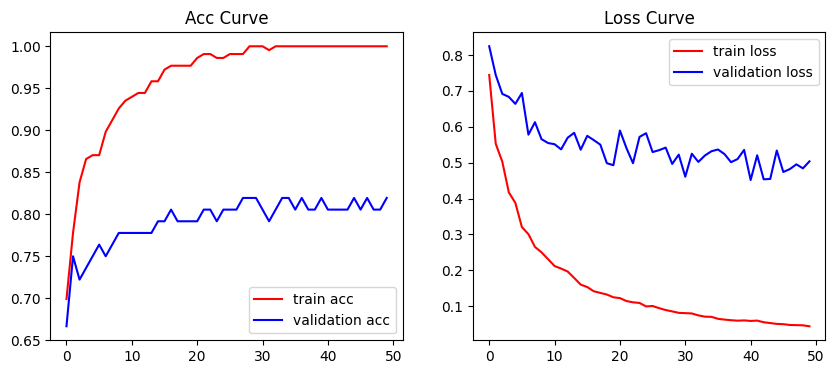

In [60]:
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red", label="train acc")
plt.plot(hist["val_acc"], color="blue", label="validation acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red", label="train loss")
plt.plot(hist["val_loss"], color="blue", label="validation loss")
plt.legend()
plt.show()

## Test

In [65]:
# load pre-trained model
# TODO: determine the `BEST` epoch
# t_best_epoch = hist["loss"].argmin()
# print(t_best_epoch)
start_epoch = 0
end_epoch = 50
best_epoch_within_range = np.argmin(hist["loss"][start_epoch:end_epoch])
print(best_epoch_within_range)
best_epoch = start_epoch + best_epoch_within_range
best_epoch = best_epoch - start_epoch
print("best epoch: {}".format(best_epoch))
# test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
test_model_path = os.path.join(savepath2, "{}-ep{}.pth".format("SCCNet_SIFI", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# testing on subject S01 test (E) session
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S03_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()
x = torch.from_numpy(x)
y = torch.from_numpy(y).long()
x = x.unsqueeze(1)
y = F.one_hot(y, 4)

print("test: {}, {}".format(x.size(), y.size()))

testset = torch.utils.data.TensorDataset(x, y)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
loss, acc, gt, pred = evalate_an_epoch(model, test_loader, loss_fn)
print(acc)

49
best epoch: 49
test: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])
0.8298611111111112


## Analyzing
You need to do some further analysis including
- confusion matrix,
- topographic maps for spatial kernel weights in SCCNet

You need to do these on your own in this section

In [66]:
# mne doc: https://mne.tools/stable/python_reference.html
# "data_detail.json" in BCI_hw3_dataset/ provides you with all channel names in this dataset. It will help you to plot a topoplot.
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sn

def plot_confusion_matrix(y_true, y_pred, labels, fn, model_name, train_scheme, acc):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)), normalize='true')
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues', values_format=".1f", ax=None)
    plt.title('Comfusion matrix\n Model: {}\n Training Scheme: {}\n Accuracy: {}'.format(model_name, train_scheme, acc))
    plt.savefig(fn, dpi=300)

In [ ]:
plot_confusion_matrix(gt, pred, [0, 1, 2, 3], os.path.join('confusion_matrice', '{}.png'.format("SCCNet_SI"))
                      , "SCCNet_SI", "SI", acc)

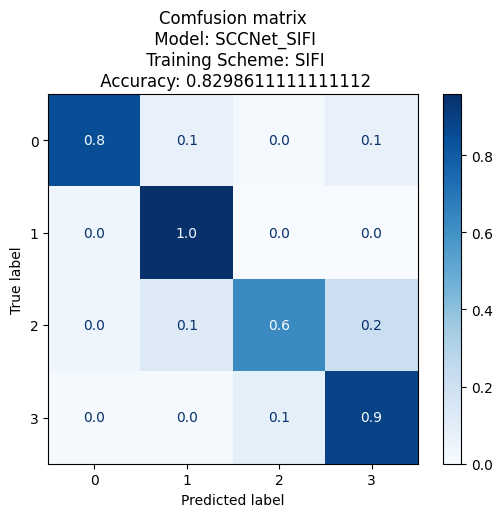

In [67]:
plot_confusion_matrix(gt, pred, [0, 1, 2, 3], os.path.join('confusion_matrice', '{}.png'.format("SCCNet_SIFI"))
                      , "SCCNet_SIFI", "SIFI", acc)

In [ ]:
plot_confusion_matrix(gt, pred, [0, 1, 2, 3], os.path.join('confusion_matrice', '{}.png'.format("EEGNet_SI"))
                      , "EEGNet", "SI", acc)

In [ ]:
plot_confusion_matrix(gt, pred, [0, 1, 2, 3], os.path.join('confusion_matrice', '{}.png'.format("EEGNet_SIFI"))
                      , "EEGNet_SIFI", "SIFI", acc)

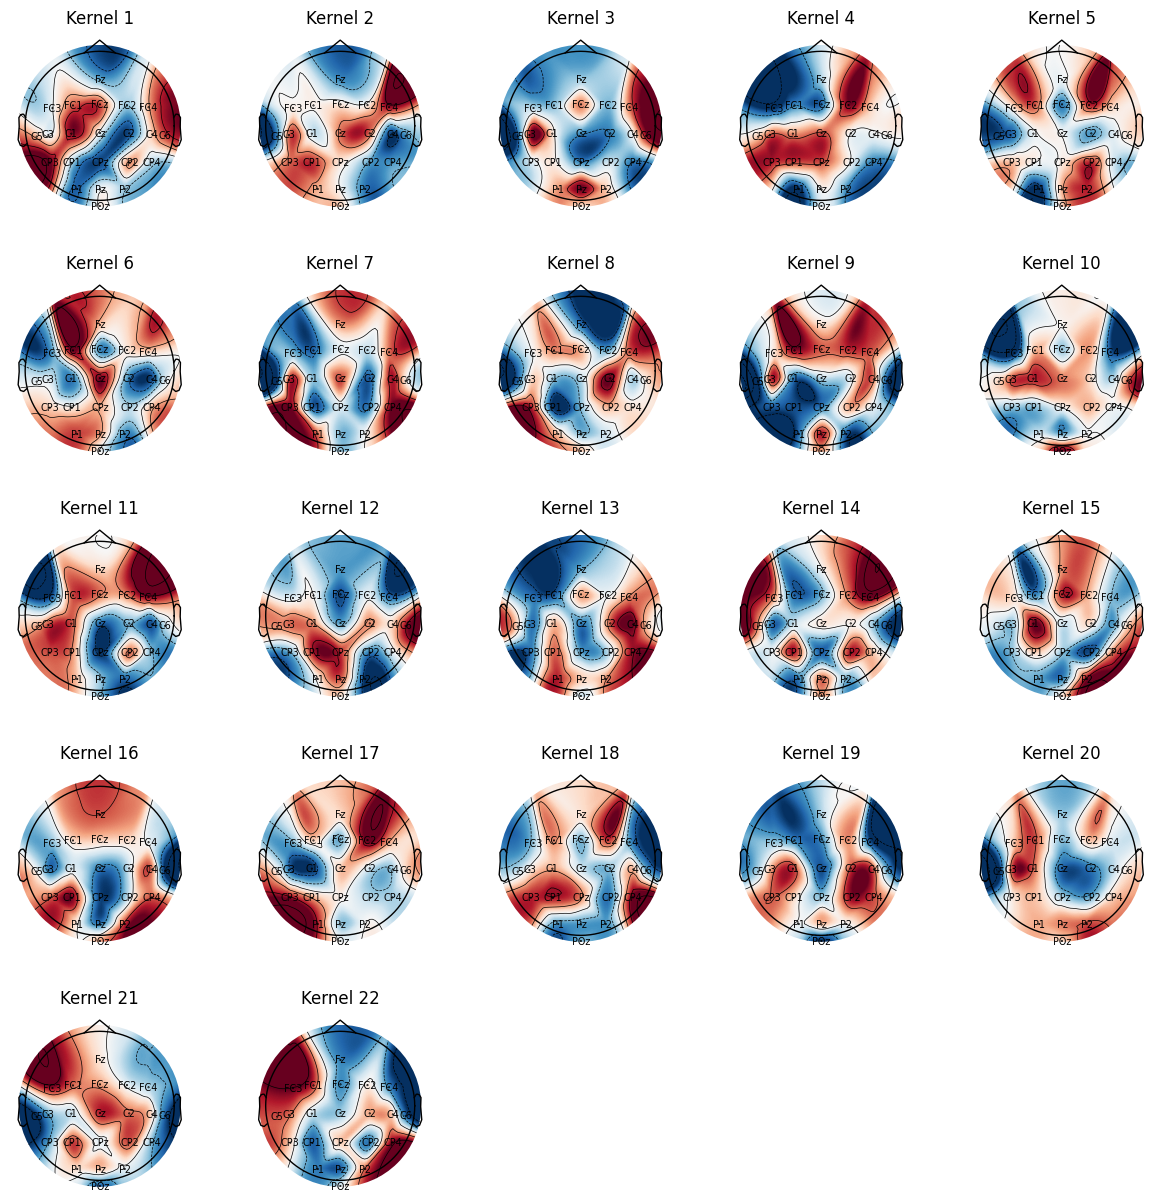

In [68]:
montage = mne.channels.make_standard_montage('standard_1020')
ch_pos = montage.get_positions()
weights = model.state_dict()['conv1.0.weight'].detach().cpu().numpy()
n_channels = weights.shape[0]
weights = weights.reshape(n_channels, -1)
weights = weights.transpose()

# Create Info object
ch_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz'
            , 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']

# Ensure ch_names and ch_pos_selected are consistent
ch_pos_selected = [ch_pos['ch_pos'][ch_name][:-1] for ch_name in ch_names]
ch_pos_selected = np.array(ch_pos_selected)

# Create Evoked object
evoked = mne.EvokedArray(weights, info, tmin=0)

# Plot topographic maps
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

# Plot topographic maps
for i, ax in enumerate(axes.flatten()):
    if i >= evoked.data.shape[1]:
        # Skip any index that is out of bounds
        ax.axis('off')  # Hide the subplot
        continue

    # Plot topomap
    mne.viz.plot_topomap(evoked.data[:, i], ch_pos_selected, names=ch_names, axes=ax, show=False)
    ax.set_title('Kernel {}'.format(i + 1))

# Hide empty subplots
for i in range(len(evoked.data.flatten()), len(axes.flatten())):
    axes.flatten()[i].axis('off')

plt.show()


## Generate Submission csv File

In [ ]:
# -----------SCCNet-----------
eegmodel = SCCNet # function alias, should be EEGNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
# -----------SCCNet-----------

# -----------EEGNet-----------
# eegmodel = EEGNet
# kwargs = dict(dropoutRate=0.5)
# -----------EEGNet-----------

model = eegmodel(22, 562, 4, **kwargs)
# best_epoch = hist["val_loss"].argmin()
start_epoch = 0
end_epoch = 50
best_epoch_within_range = np.argmin(hist["loss"][start_epoch:end_epoch])
best_epoch = start_epoch + best_epoch_within_range
best_epoch = best_epoch - start_epoch
print(best_epoch)
# test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
# test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("SCCNet", best_epoch))
test_model_path = os.path.join(savepath2, "{}-ep{}.pth".format("SCCNet_SIFI", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")
model.load_state_dict(checkpoint["state_dict"])

model.eval()
fd = open("simple_sd.csv", "w")
csv_writer = csv.writer(fd)
csv_writer.writerow(["id", "Category"])
for sid in ["05", "06", "0A", "0B", "0C"]:
    mat = loadmat(os.path.join(DATASET_DIR_EXAM, f"BCIC_S{sid}_E.mat"))
    x = torch.from_numpy(mat["x_test"])
    x = x.unsqueeze(1).to(device, dtype=torch.float)
    p = model(x).argmax(dim=1).detach().cpu().numpy()
    for epoch_id, label in enumerate(p):
        csv_writer.writerow([f"S{sid}_{epoch_id}", label])
fd.close()